In [1]:
import io
from typing import List

import torch
import torchvision.transforms as T
from fastapi import FastAPI, File, Form, Response, UploadFile
from models.boq_embeddings import BOQEmbeddings
from models.pixel_effect_module import PixelEffectModule
from PIL import Image, ImageOps

In [2]:
CHUNK_SIZE =512
SEED = 148177255

In [3]:
# Set device for model and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load the model
boq_model = BOQEmbeddings(device=device, chunk_size= CHUNK_SIZE)

from labeled_image_dataset import LabeledImageDataset
whole_dataset = LabeledImageDataset("dataset")
whole_dataset._shuffle(seed=SEED, shuffle_inter_label=True, shuffle_row_pairs=False)

from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(whole_dataset.dataframe, test_size=0.2, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

train_dataset = LabeledImageDataset("dataset", dataframe=train_df)
val_dataset = LabeledImageDataset("dataset", dataframe=val_df,  transform = boq_model.transform)

len(val_dataset)

Using cache found in /home/j-k11b104/.cache/torch/hub/facebookresearch_dinov2_main
/home/j-k11b104/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/j-k11b104/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/j-k11b104/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


52951

In [11]:
val_dataset.dataframe["global_label"].value_counts(

62758     59213
523489    51695
75540      1264
216392    12451
455331    36124
          ...  
253292    12996
229265     7094
123569    25534
479943    57379
490918    29706
Name: global_label, Length: 52951, dtype: int64

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm  # Import tqdm for progress bars

# Prepare the DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=boq_model.chunk_size, shuffle=False)

# Function to get embeddings and labels for the entire dataset
def get_embeddings_and_labels(model, data_loader):
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for img_batch, label_batch in tqdm(data_loader, desc='Embedding Batches'):
            img_batch = img_batch.to(device)
            embedding_batch = model.embed_tensors(img_batch)
            embeddings.append(embedding_batch.cpu())
            labels.extend(label_batch.numpy())
    
    embeddings = torch.cat(embeddings, dim=0).numpy()
    labels = np.array(labels)
    return embeddings, labels

# Get embeddings and labels for validation set
embeddings, labels = get_embeddings_and_labels(boq_model, val_loader)

Embedding Batches: 100%|██████████| 104/104 [45:51<00:00, 26.45s/it]


In [5]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
from tqdm import tqdm

# Calculate cosine distances in a single operation
distance_matrix = cosine_distances(embeddings)

In [6]:
# Create boolean mask for same and different labels
same_label_mask = labels[:, None] == labels  # True if same label, False otherwise
diff_label_mask = ~same_label_mask  # Complement of same_label_mask

# Extract distances using the masks
same_label_distances = distance_matrix[same_label_mask & np.triu(same_label_mask, k=1)]
diff_label_distances = distance_matrix[diff_label_mask & np.triu(diff_label_mask, k=1)]

# Calculate mean and std for each category
same_label_mean = np.mean(same_label_distances)
same_label_std = np.std(same_label_distances)
diff_label_mean = np.mean(diff_label_distances)
diff_label_std = np.std(diff_label_distances)

# Display results
print(f"Same-label cosine distance - Mean: {same_label_mean:.4f}, Std: {same_label_std:.4f}")
print(f"Different-label cosine distance - Mean: {diff_label_mean:.4f}, Std: {diff_label_std:.4f}")

Same-label cosine distance - Mean: 0.6880, Std: 0.1158
Different-label cosine distance - Mean: 0.9999, Std: 0.0134


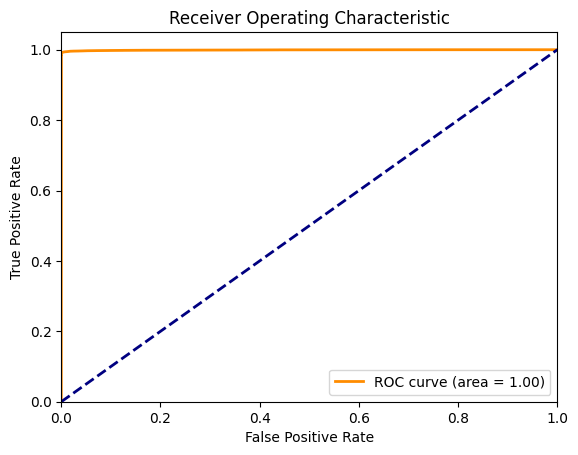

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

distances = np.concatenate([same_label_distances, diff_label_distances])
labels_binary = np.concatenate([np.ones(len(same_label_distances)), np.zeros(len(diff_label_distances))])

fpr, tpr, thresholds = roc_curve(labels_binary, -distances)  # Negative distances because closer distances mean higher similarity
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


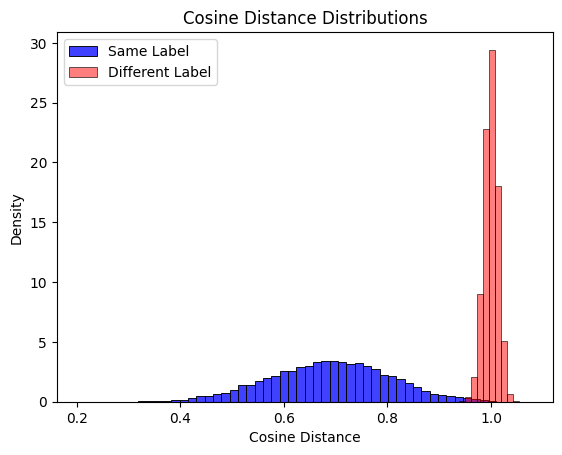

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(same_label_distances, color='blue', label='Same Label', stat='density', bins=50)
sns.histplot(diff_label_distances, color='red', label='Different Label', stat='density', bins=50, alpha=0.5)
plt.legend()
plt.xlabel('Cosine Distance')
plt.ylabel('Density')
plt.title('Cosine Distance Distributions')
plt.show()


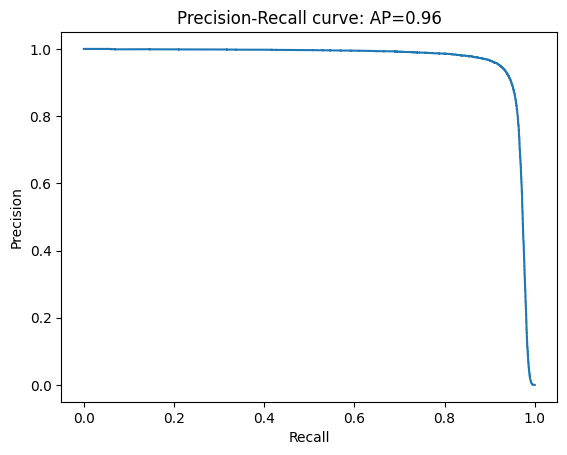

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(labels_binary, -distances)
average_precision = average_precision_score(labels_binary, -distances)

plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve: AP={average_precision:.2f}')
plt.show()


In [10]:
# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Adding a small epsilon to avoid division by zero

# Find the index of the maximum F1 score
best_index = f1_scores.argmax()
best_threshold = thresholds[best_index]
best_f1_score = f1_scores[best_index]

print(f"Optimal threshold for maximum F1 score: {-best_threshold:.4f}")
print(f"Maximum F1 score: {best_f1_score:.4f}")


Optimal threshold for maximum F1 score: 0.8491
Maximum F1 score: 0.9365
